In [2]:
import nibabel as nib
from matplotlib import pyplot as plt
import os
import pickle
import numpy as np

#NN
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K

# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

# GPU
from tensorflow.python.client import device_lib

### Define Metrics

In [14]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [15]:
gamma = 2
alpha = .25
def focal_loss_fixed(y_true, y_pred):
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

In [17]:
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

### Define data paths for rerun of metrics

In [28]:
#base_path="C:/Users/drago/Documents/gitrepos/individual-project-alzhiemers_detection/MRI Data/WM parc data - cropped images/Blur_Contour_Crop/"
base_path="C:/Users/matth/OneDrive - University of Reading/Documents/Year 3 Documents/Final Year Project/Git Large File Storage/MRI Data/WM parc data - cropped images/Blur_Contour_Expand_Crop/"
cross_val = "C:/Users/matth/OneDrive - University of Reading/Documents/Year 3 Documents/Final Year Project/Git Large File Storage/MRI Data/WM parc data - cropped images/Blur_Contour_Expand_Crop-Cats_Combined/"

In [29]:
# File setup check
print("Total Cross Validation AD: ", len(os.listdir(cross_val+"Cross_Val/AD")))
print("Total testing AD: ", len(os.listdir(cross_val+"Test/AD")))

print("\nTotal Cross Validation CN: ", len(os.listdir(cross_val+"Cross_Val/CN")))
print("Total testing CN: ", len(os.listdir(cross_val+"Test/CN")))

cv_val_size = len(os.listdir(cross_val+"Cross_Val/AD"))+len(os.listdir(cross_val+"Cross_Val/CN"))
train_size = len(os.listdir(base_path+"1-Train/AD"))+len(os.listdir(base_path+"1-Train/CN"))
valid_size = len(os.listdir(base_path+"2-Validation/AD"))+len(os.listdir(base_path+"2-Validation/CN"))
test_size = len(os.listdir(cross_val+"Test/AD"))+len(os.listdir(cross_val+"Test/CN"))

print("\nTotal Cross Validation Data: ", cv_val_size)
print("Total Training Data: ", train_size)
print("Total Validation Data: ", valid_size)
print("Total Test Data: ", test_size)

Total Cross Validation AD:  293
Total testing AD:  97

Total Cross Validation CN:  536
Total testing CN:  179

Total Cross Validation Data:  829
Total Training Data:  553
Total Validation Data:  276
Total Test Data:  276


### Define results directories

In [30]:
base_directory = "C:/Users/matth/OneDrive - University of Reading/Documents/Year 3 Documents/Final Year Project/Git Large File Storage/Models/one-slice-data/VGG16_Hypertuned_Fit_Batch32_Img256_76 - 3_1/"
best_model_file = base_directory + "best_model.hdf5"
history_file_name = base_directory + "History.pkl"

### Load history and model

In [31]:
# Get history
with open(history_file_name, 'rb') as file__pi:
    VGG16_history = pickle.load(file__pi)
    
# Get best model
VGG16_best = models.load_model(best_model_file, custom_objects={"focal_loss_fixed": focal_loss_fixed, "get_f1": get_f1, "matthews_correlation": matthews_correlation})

### Define data generators

In [32]:
batch_size = 32

test_aug_datagen = ImageDataGenerator(rescale=1./256)

In [33]:
validation_aug_generator = test_aug_datagen.flow_from_directory(
    base_path+"2-Validation/",
    target_size=(256,256),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False)

Found 276 images belonging to 2 classes.


### Get history and plot results

In [34]:
accuracy = VGG16_history['acc']
validation_accuracy = VGG16_history['val_acc']

loss = VGG16_history['loss']
validation_loss = VGG16_history['val_loss']


valid_acc:  0.76811594
valid_loss:  0.05760179956754049
valid_precision:  0.8176796
valid_recall:  0.82681566
valid_f1:  0.6005771
valid_mcc:  0.04154203


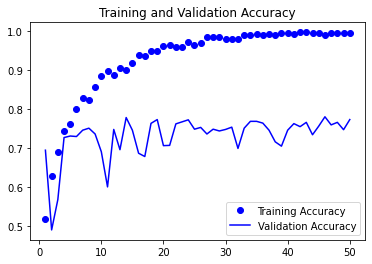

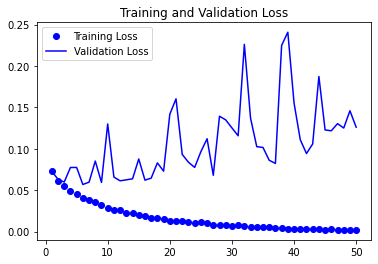

<Figure size 432x288 with 0 Axes>

In [35]:
epochs = range(1, len(accuracy) + 1)

# Accuracy Plots
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()

# Loss Plots
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.figure()

# Generate acc loss percentages
valid_loss, valid_acc, valid_precision, valid_recall, valid_f1, valid_mcc = VGG16_best.evaluate_generator(
                                                                                        validation_aug_generator, 
                                                                                        steps=len(validation_aug_generator))
print("\nvalid_acc: ", valid_acc)
print("valid_loss: ", valid_loss)
print("valid_precision: ", valid_precision)
print("valid_recall: ", valid_recall)
print("valid_f1: ", valid_f1)
print("valid_mcc: ", valid_mcc)

In [36]:
# Classification metric matrix: precision, recall, f1-score, support
val_preds = np.round(VGG16_best.predict_generator(validation_aug_generator),0)
val_trues = validation_aug_generator.classes

# Label data
classes = np.array(list(validation_aug_generator.class_indices.keys()))

print(classification_report(val_trues, val_preds))

              precision    recall  f1-score   support

           0       0.67      0.66      0.67        97
           1       0.82      0.83      0.82       179

    accuracy                           0.77       276
   macro avg       0.75      0.74      0.74       276
weighted avg       0.77      0.77      0.77       276

